In [26]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [27]:

# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
#     -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item.append(row[5])
        row_label = row[0]
        if row_label == '1':
            list_item.append(1)
        else:
            list_item.append(0)
        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [28]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [101]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0]) # YOUR CODE HERE)
    labels.append(corpus[x][1]) # YOUR CODE HERE)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) # YOUR CODE HERE)

word_index = tokenizer.word_index
vocab_size=len(word_index) # YOUR CODE HERE)

sequences = tokenizer.texts_to_sequences(sentences)# YOUR CODE HERE)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)# YOUR CODE HERE)

split = int(test_portion * training_size)

test_sequences = padded[0:split] # YOUR CODE HERE]
training_sequences = padded[split:] # YOUR CODE HERE]
test_labels = labels[0:split]# YOUR CODE HERE]
training_labels = labels[split:]# YOUR CODE HERE]

In [102]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138812
1


In [103]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [92]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138558


In [99]:
len(training_sequences[1])

44

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# YOUR CODE HERE)
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 16, 100)           13881300  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 13,966,069
Trainable params: 84,769
Non-trainable params: 13,881,300
_________________________________________________________________


In [112]:
for var in model.layers[3].variables:
    print(var.shape)

(128, 128)
(32, 128)
(128,)


In [107]:
model.layers[3].variables

[<tf.Variable 'lstm_7/kernel:0' shape=(128, 128) dtype=float32, numpy=
 array([[-0.02242157,  0.06443235, -0.03254837, ...,  0.12340783,
         -0.06035699, -0.03764456],
        [-0.03556702,  0.14940634,  0.17009735, ...,  0.06359382,
          0.07338122, -0.05808947],
        [ 0.14072074, -0.07477003,  0.03190565, ...,  0.08009797,
         -0.06125277,  0.15329967],
        ...,
        [ 0.05574236,  0.04145518, -0.07747411, ...,  0.08934958,
         -0.02045109,  0.14906257],
        [-0.0690292 ,  0.03378295, -0.07943306, ..., -0.04386041,
          0.14763202, -0.11425418],
        [ 0.02836514, -0.02936734,  0.12378414, ...,  0.12059878,
         -0.11477554, -0.08012311]], dtype=float32)>,
 <tf.Variable 'lstm_7/recurrent_kernel:0' shape=(32, 128) dtype=float32, numpy=
 array([[ 0.09612014,  0.0304251 ,  0.02096255, ..., -0.02987007,
          0.03569466, -0.03078489],
        [-0.13245998, -0.17878687,  0.06762763, ..., -0.20869896,
         -0.02409156, -0.0489521 ],
  

In [75]:
training_sequences

array([[   0,    0,    0, ..., 4207,   10, 2567],
       [   0,    0,    0, ...,   13, 5897,  535],
       [   0,    0,    0, ...,   10,   26, 2312],
       ...,
       [   0,    0,    0, ...,   10,    5,  325],
       [   0,    0,    0, ..., 6600,    6,  390],
       [   0,    0,    0, ...,  202, 3899,   30]], dtype=int32)

In [105]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

In [106]:

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Train on 144000 samples, validate on 16000 samples
Epoch 1/50
144000/144000 - 26s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.0715e-05 - val_accuracy: 1.0000
Epoch 2/50
144000/144000 - 23s - loss: 4.0353e-06 - accuracy: 1.0000 - val_loss: 1.0217e-06 - val_accuracy: 1.0000
Epoch 3/50
144000/144000 - 23s - loss: 4.0543e-07 - accuracy: 1.0000 - val_loss: 1.0830e-07 - val_accuracy: 1.0000
Epoch 4/50
144000/144000 - 23s - loss: 4.3625e-08 - accuracy: 1.0000 - val_loss: 1.2241e-08 - val_accuracy: 1.0000
Epoch 5/50
144000/144000 - 17s - loss: 5.3363e-09 - accuracy: 1.0000 - val_loss: 1.9298e-09 - val_accuracy: 1.0000
Epoch 6/50
144000/144000 - 17s - loss: 1.0864e-09 - accuracy: 1.0000 - val_loss: 6.1812e-10 - val_accuracy: 1.0000
Epoch 7/50
144000/144000 - 17s - loss: 4.4723e-10 - accuracy: 1.0000 - val_loss: 3.3207e-10 - val_accuracy: 1.0000
Epoch 8/50
144000/144000 - 17s - loss: 2.7119e-10 - accuracy: 1.0000 - val_loss: 2.2467e-10 - val_accuracy: 1.0000
Epoch 9/50
144000/144000 - 17s - 

<Figure size 576x396 with 0 Axes>

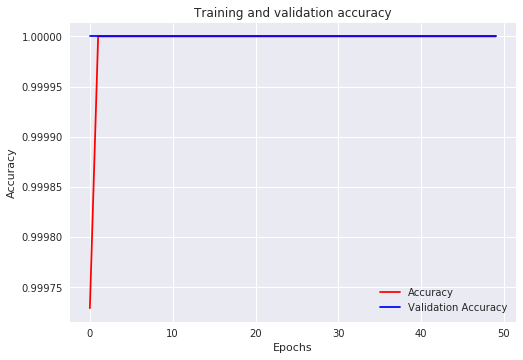

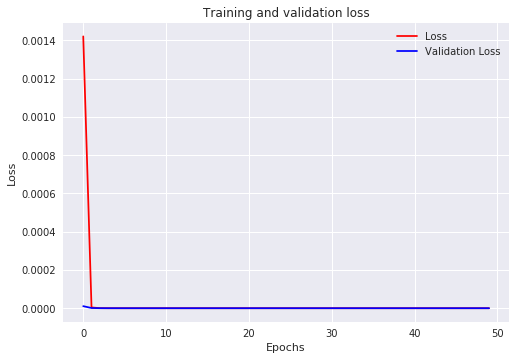

<Figure size 576x396 with 0 Axes>

In [111]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.style.use('seaborn')
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!